In [1]:
import optuna
import yaml
import json
from sklearn.metrics import f1_score
from typing import Any, Dict, Tuple
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer, RobustScaler, MinMaxScaler,
    FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import  accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
import numpy as np
from utils_machine_learning import rename_columns_to_snake_case

from custom_transformers import (
    DropRedundantColumns,
    CreateNewFeature,

    LogTransformer,
    PowerTransformerWrapper,
    OutlierTransformer,
    OutlierDetector,
    ReplaceValueTransformer,
    OutlierHandler,

)
from optuna.samplers import TPESampler
from sklearn.decomposition import PCA

import joblib
from typing import Union

from imblearn.over_sampling import (
    RandomOverSampler,
    ADASYN,
    
)
from imblearn.under_sampling import (
    RandomUnderSampler,
    NearMiss,
)
from imblearn.combine import (
    SMOTEENN,
    SMOTETomek
)
pd.set_option('future.no_silent_downcasting', True)

In [2]:
# load the dataset
def load_dataset() -> pd.DataFrame:
    """
    Load the dataset from the CSV file and return it as a pandas DataFrame.

    Args:
        None

    Returns:
        pd.DataFrame: The dataset loaded from the CSV file.
    """
    
    data_path = 'https://github.com/donadviser/datasets/raw/master/data-don/auto_insurance_claim_fraud.csv'
    data = pd.read_csv(data_path, sep=",")
    return (data
            .pipe(rename_columns_to_snake_case)
            #.dropna()
            )

In [3]:
data_raw = load_dataset()
data_raw.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [4]:
data_raw[['capital_gains', 'capital_loss', 'umbrella_limit']]

,capital_gains,capital_loss,umbrella_limit
0,53300,0,0
1,0,0,5000000
2,35100,0,5000000
3,48900,-62400,6000000
4,66000,-46000,6000000
...,...,...,...
995,0,0,0
996,70900,0,0
997,35100,0,3000000
998,0,0,5000000


In [5]:
onehot_features = ['policy_state', 'collision_type', 'property_damage', 'police_report_available', 
                  'insured_sex', 'insured_education_level', 'insured_relationship', 'incident_type', 
                  'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 
                  'policy_deductable', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 
                  'incident_period_of_day']

numerical_features = ['months_as_customer',  'age', 'policy_annual_premium', 'injury_claim', 
                      'property_claim', 'vehicle_claim', 'vehicle_age','total_claim_amount']

ordinal_features = ['insured_occupation', 'insured_hobbies', 'auto_make']

transform_features = ['umbrella_limit', 'capital_gains', 'capital_loss']

drop_columns = ['policy_number','policy_bind_date','policy_csl', 'insured_zip','incident_date',
                'incident_location','auto_model','auto_year', 'incident_hour_of_the_day',
                ]

bins_hour = [0, 6, 11, 16, 21, 24]  # Time bins for different periods of the day
names_period = ["early_morning", "morning", "afternoon", "evening", "night"] 

target_col = 'fraud_reported'

In [6]:
# Assuming dataset is loaded in a pandas dataframe
X, y = data_raw.drop(columns=[target_col]), data_raw[target_col]

# Splitting the dataset
y = y.map({'Y': 1, 'N': 0})  # Map target labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Load YAML configuration file
def load_yaml_config(config_path: str) -> Dict[str, Any]:
    """
    Load the YAML configuration file containing model and hyperparameter definitions.

    Args:
        config_path (str): Path to the YAML configuration file.

    Returns:
        Dict[str, Any]: The loaded configuration as a dictionary.
    """
    with open(config_path, "r") as file:
        return yaml.safe_load(file)

In [8]:
class HyperparameterTuner:
    """
    HyperparameterTuner to return hyperparameters for each classifier.
    """
    def get_params(self, trial: optuna.Trial, classifier_name: str):
        if classifier_name == "RandomForest":
            return {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "max_depth": trial.suggest_int("max_depth", 2, 30),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
            }
        elif classifier_name == "DecisionTree":
            return {
                "max_depth": trial.suggest_int("max_depth", 2, 30),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
            }
        elif classifier_name == "LGBM":
            return {
                "objective": "binary",
                "metric": "binary_logloss",
                "verbosity": -1,
                "boosting_type": "gbdt",
                "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                "num_leaves": trial.suggest_int("num_leaves", 2, 256),
                "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
                "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
                "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
                "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            }
        elif classifier_name == "XGBoost":
            return {
                "verbosity": 0,
                "objective": "binary:logistic",
                "eval_metric": "auc",
                "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
                "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
                "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
                "subsample": trial.suggest_float("subsample", 0.2, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
            }
        elif classifier_name == "CatBoost":
            return {
                "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
                "depth": trial.suggest_int("depth", 1, 12),
                "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
            }
        elif classifier_name == "LogisticRegression":
            # Basic hyperparameters
            params = {
                "solver": trial.suggest_categorical('solver', ['newton-cholesky', 'lbfgs', 'liblinear', 'sag', 'saga']),
                "max_iter": trial.suggest_int('max_iter', 10000, 50000),  # Increased max_iter to allow for better convergence
            }

            # Suggest penalty from a unified set
            all_penalties = ['l1', 'l2', 'elasticnet', None]  # Unified penalties
            params['penalty'] = trial.suggest_categorical('penalty', all_penalties)

            # Only suggest C if penalty is not None
            if params['penalty'] is not None:
                params["C"] = trial.suggest_float('C', 1e-10, 1000, log=True)
            
            # Only suggest l1_ratio if penalty is 'elasticnet'
            if params['penalty'] == 'elasticnet':
                params['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)

            # Prune invalid combinations:
            if (
                (params['solver'] == 'lbfgs' and params['penalty'] not in ['l2', None]) or
                (params['solver'] == 'liblinear' and params['penalty'] not in ['l1', 'l2']) or
                (params['solver'] == 'sag' and params['penalty'] not in ['l2', None]) or
                (params['solver'] == 'newton-cholesky' and params['penalty'] not in ['l2', None]) or
                (params['solver'] == 'saga' and params['penalty'] not in ['elasticnet', 'l1', 'l2', None])
            ):
                raise optuna.TrialPruned()  # Invalid combination of solver and penalty

            return params

        
        elif classifier_name == "GradientBoosting":
            return {
                "learning_rate" : trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
                "n_estimators" : trial.suggest_int('n_estimators', 100, 1000),
                "max_depth" : trial.suggest_int('max_depth', 3, 10),
                "min_samples_split" : trial.suggest_int('min_samples_split', 2, 20),
                "min_samples_leaf" : trial.suggest_int('min_samples_leaf', 1, 20),
                "max_features" : trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
            }
        elif classifier_name == "KNeighbors":
            params = {
                "n_neighbors": trial.suggest_int('n_neighbors', 1, 50),
                "weights": trial.suggest_categorical('weights', ['uniform', 'distance']),
                "p": trial.suggest_int('p', 1, 2),  # 1: Manhattan, 2: Euclidean
                "leaf_size": trial.suggest_int('leaf_size', 10, 100),
                "metric": trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski', 'chebyshev'])
            }
            return params
        else:
            raise ValueError(f"Invalid classifier name: {classifier_name}")

In [9]:
class ModelFactory:
    """
    A class to create model instances with additional parameters for specific classifiers.

    Attributes:
        model_name (str): The name of the model to be instantiated.
        best_params (dict): The best hyperparameters for the model.
    """

    def __init__(self, model_name: str, best_params: dict):
        """
        Initialize the ModelFactory with a model name and parameters.
        
        Args:
            model_name (str): The name of the model.
            best_params (dict): Hyperparameters for the model.
        """
        self.model_name = model_name
        self.best_params = best_params

    def get_model_instance(self):
        """
        Creates a model instance based on the model name with additional classifier-specific parameters.

        Returns:
            A model instance with the appropriate parameters.
        """
        # Dictionary of model classes
        model_dict = {
            "LGBM": LGBMClassifier,
            "XGBoost": XGBClassifier,
            "CatBoost": CatBoostClassifier,
            "RandomForest": RandomForestClassifier,
            "DecisionTree": DecisionTreeClassifier,
            "LogisticRegression": LogisticRegression,
            "SVC": SVC,
            "GradientBoosting": GradientBoostingClassifier,
            "KNeighbors": KNeighborsClassifier
        }

        # Check if the model exists in the model_dict
        if self.model_name not in model_dict:
            raise ValueError(f"Model {self.model_name} is not supported.")

        # Create a model instance with specific parameters
        if self.model_name == "LGBM":
            return model_dict[self.model_name](**self.best_params, random_state=42, verbose=-1)  # Add verbose for LGBM
        elif self.model_name == "RandomForest":
            return model_dict[self.model_name](**self.best_params, random_state=42, n_jobs=-1)  # Add n_jobs for RandomForest
        elif self.model_name == "SVC":
            return model_dict[self.model_name](**self.best_params, random_state=42, probability=True)  # Add probability for SVC
        elif self.model_name == "CatBoost":
            return model_dict[self.model_name](**self.best_params, random_state=42, verbose=0)  # Suppress CatBoost verbosity
        elif self.model_name == "KNeighbors":
            return model_dict[self.model_name](**self.best_params)  # Suppress CatBoost verbosity
        else:
            return model_dict[self.model_name](**self.best_params, random_state=42)  # Default for other models

In [10]:
class PipelineManager:
    """
    A class that handles both building and modifying pipelines dynamically.
    This class supports both scikit-learn's Pipeline and imbalanced-learn's Pipeline.

    It allows the construction of the initial pipeline and the insertion of steps 
    at any position within the pipeline.
    """

    def __init__(self, pipeline_type='ImbPipeline'):
        """
        Initialize the PipelineManager with a specified pipeline type.

        Args:
            pipeline_type (str): The type of pipeline to use ('ImbPipeline' or 'Pipeline').
        """
        if pipeline_type == 'ImbPipeline':
            self.pipeline = ImbPipeline(steps=[])
        elif pipeline_type == 'Pipeline':
            self.pipeline = Pipeline(steps=[])
        else:
            raise ValueError("Unsupported pipeline type. Choose 'ImbPipeline' or 'Pipeline'.")

    def add_step(self, step_name, step_object, position=None):
        """
        Add a transformation step to the pipeline.

        Args:
            step_name (str): Name of the step to add.
            step_object (object): The transformer or estimator object (e.g., scaler, classifier).
            position (int or None): Optional; the position to insert the step.
                                    If None, the step is appended at the end of the pipeline.
        """
        if position is None:
            self.pipeline.steps.append((step_name, step_object))
        else:
            self.pipeline.steps.insert(position, (step_name, step_object))

    def remove_step(self, step_name):
        """
        Remove a step from the pipeline by its name.

        Args:
            step_name (str): The name of the step to remove.
        """
        self.pipeline.steps = [(name, step) for name, step in self.pipeline.steps if name != step_name]

    def replace_step(self, step_name, new_step_object):
        """
        Replace an existing step in the pipeline with a new step.

        Args:
            step_name (str): The name of the step to replace.
            new_step_object (object): The new transformer or estimator object.
        """
        for i, (name, step) in enumerate(self.pipeline.steps):
            if name == step_name:
                self.pipeline.steps[i] = (step_name, new_step_object)
                break

    def get_pipeline(self):
        """
        Get the constructed or modified pipeline.

        Returns:
            Pipeline: The constructed or modified pipeline object.
        """
        return self.pipeline

In [11]:
class PreprocessingPipeline:
    """
    A class that encapsulates the preprocessing steps for feature engineering,
    imputation, scaling, encoding, and transformations. This can be inserted into
    the overall pipeline before the model fitting step.
    """
    def __init__(self, bins_hour, names_period, drop_columns, numerical_features,
                 onehot_features, ordinal_features, transform_features, trial: optuna.Trial=None):
        """
        Initialize the PreprocessingPipeline with necessary parameters.

        Args:
            bins_hour: Parameters for creating new features from hourly bins.
            names_period: Period names for feature creation.
            drop_columns: Columns to be dropped from the dataset.
            numerical_features: List of numerical features for processing.
            onehot_features: List of categorical features for OneHot encoding.
            ordinal_features: List of ordinal features for Ordinal encoding.
            transform_features: Features that require power transformation.
        """
        self.bins_hour = bins_hour
        self.names_period = names_period
        self.drop_columns = drop_columns
        self.numerical_features = numerical_features
        self.onehot_features = onehot_features
        self.ordinal_features = ordinal_features
        self.transform_features = transform_features
        
    def instantiate_numerical_simple_imputer(self, trial: optuna.Trial=None, strategy: str=None, fill_value: int=-1) -> SimpleImputer:
        if strategy is None and trial:
            strategy = trial.suggest_categorical(
                'numerical_strategy', ['mean', 'median', 'most_frequent']
            )
        #print(f"instantiate_numerical_simple_imputer: strategy= {strategy}")
        return SimpleImputer(strategy=strategy, fill_value=fill_value)

    def instantiate_categorical_simple_imputer(self, trial: optuna.Trial=None, strategy: str=None, fill_value: str='missing') -> SimpleImputer:
        if strategy is None and trial:
            strategy = trial.suggest_categorical('categorical_strategy', ['most_frequent', 'constant'])
        #print(f"instantiate_categorical_simple_imputer: strategy= {strategy}")
        return SimpleImputer(strategy=strategy, fill_value=fill_value)
    
    def instantiate_outliers(self, trial: optuna.Trial=None, strategy=None) -> Union[PowerTransformer, FunctionTransformer, OutlierDetector]:
        """
        Instantiate outlier handling method: PowerTransformer, LogTransformer, or OutlierDetector.

        Args:
            trial (optuna.Trial, optional): The trial object for hyperparameter optimization.

        Returns:
            Union[PowerTransformer, FunctionTransformer, OutlierDetector]: The selected outlier handling method.
        """
        # Suggest from available options
        options = ['power_transform', 'log_transform', 'iqr_clip', 'iqr_median', 'iqr_mean']
        if trial:
            strategy = trial.suggest_categorical('outlier_strategy', options)
        else:
            strategy = strategy  # Default to first option if no trial is provided

        if strategy == 'power_transform':
            return PowerTransformer(method='yeo-johnson')
        elif strategy == 'log_transform':
            return LogTransformer()
            #return FunctionTransformer(np.log1p)  # Log transformation
        elif strategy in ['iqr_clip', 'iqr_median', 'iqr_mean']:
            return OutlierHandler(strategy=strategy)  # Instantiate OutlierDetector
        else:
            raise ValueError(f"Unknown strategy for outlier handling: {strategy}")

         
    def build(self, step_name=None, trial: optuna.Trial=None, **column_transformer_strategy):
        """
        Build the preprocessing pipeline with feature creation, transformation, 
        imputation, scaling, and encoding steps.
        
        Returns:
            Transformer: The appropriate transformer for the given step.
        """
        
        if step_name == "create_new_features":
            return CreateNewFeature(bins_hour=self.bins_hour, names_period=self.names_period)
        
        if step_name == "replace_class":
            return ReplaceValueTransformer(old_value="?", new_value=np.nan)
        
        if step_name == "drop_cols":
            return DropRedundantColumns(redundant_cols=self.drop_columns)
        
        if step_name == 'column_transformer':
            
            numerical_strategy = column_transformer_strategy.get('numerical_strategy', None)
            categorical_strategy = column_transformer_strategy.get('categorical_strategy',None)
            outlier_strategy = column_transformer_strategy.get('outlier_strategy', None)
        
            
            return ColumnTransformer(
                transformers=[
                    ('categorical', Pipeline([
                        ('imputer', self.instantiate_categorical_simple_imputer(trial=trial, strategy=categorical_strategy)),   
                        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
                    ]), self.onehot_features),
                    
                    ('numerical', Pipeline([
                        ('imputer', self.instantiate_numerical_simple_imputer(trial=trial, strategy=numerical_strategy)),
                        #('scaler', StandardScaler())  # Add scaler if needed
                    ]), self.numerical_features),
                    
                    
                    
                    ('ordinal', Pipeline([
                        ('imputer', self.instantiate_categorical_simple_imputer(trial=trial, strategy=categorical_strategy)),
                        ('ordinal', OrdinalEncoder())
                    ]), self.ordinal_features),
                    
                    ('outlier_transform', Pipeline([
                        ('imputer', self.instantiate_numerical_simple_imputer(trial=trial, strategy=numerical_strategy)),
                        ('outlier_transformer', self.instantiate_outliers(trial=trial, strategy=outlier_strategy))  # Update this line
                    ]), self.transform_features),
                ],
                remainder='passthrough'
            )


In [12]:
class ResamplerSelector:
    """
    A class to select and return a resampling algorithm based on a given parameter or 
    from a trial suggestion if available.

    Attributes:
        trial (optuna.trial, optional): The trial object for hyperparameter optimization.
    """

    def __init__(self, trial=None, random_state=42):
        """
        Initialize the ResamplerSelector with an optional trial for hyperparameter optimization.

        Args:
            trial (optuna.trial, optional): An optional trial object for suggesting resampling strategies.
            random_state (int): Random seed for reproducibility. Default is 42.
        """
        self.trial = trial
        self.random_state = random_state

    def get_resampler(self, resampler=None):
        """
        Return the resampling algorithm based on the provided `resampler` parameter.
        If `resampler` is not given, it is suggested from the trial.

        Args:
            resampler (str, optional): The resampling method ('RandomOverSampler', 'ADASYN', etc.). 
                                       If not provided, it will be suggested from the trial (if available).

        Returns:
            resampler_obj (object): The resampling instance based on the selected method.
        """
        if resampler is None and self.trial:
            resampler = self.trial.suggest_categorical(
                'resampler', ['RandomOverSampler', 'SMOTEENN', 'SMOTETomek']
            )
            #['RandomOverSampler', 'ADASYN', 'RandomUnderSampler', 'NearMiss', 'SMOTEENN', 'SMOTETomek']

        if resampler == 'RandomOverSampler':
            return RandomOverSampler(random_state=self.random_state)
        elif resampler == 'ADASYN':
            return ADASYN(random_state=self.random_state)
        elif resampler == 'RandomUnderSampler':
            return RandomUnderSampler(random_state=self.random_state)
        elif resampler == 'NearMiss':
            return NearMiss()
        elif resampler == 'SMOTEENN':
            return SMOTEENN(random_state=self.random_state, sampling_strategy='minority' )
        elif resampler == 'SMOTETomek':
            return SMOTETomek(random_state=self.random_state)
        else:
            raise ValueError(f"Unknown resampler: {resampler}")

In [13]:
class ScalerSelector:
    """
    A class to select and return a scaling algorithm based on a given parameter or 
    from a trial suggestion if available.

    Attributes:
        trial (optuna.trial, optional): The trial object for hyperparameter optimization.
    """

    def __init__(self, trial=None):
        """
        Initialize the ScalerSelector with an optional trial for hyperparameter optimization.

        Args:
            trial (optuna.trial, optional): An optional trial object for suggesting resampling strategies.
        """
        self.trial = trial

    def get_scaler(self, scaler_name=None):
        """
        Return the scaling algorithm based on the provided `scaler_name` parameter.
        If `scaler_name` is not given, it is suggested from the trial.

        Args:
            scaler_name (str, optional): The scalring method ('MinMaxScaler', 'StandardScaler', etc.). 
                                       If not provided, it will be suggested from the trial (if available).

        Returns:
            rscaler_obj (object): The scaling instance based on the selected method.
        """ 
         
        # -- Instantiate scaler (skip scaler for CatBoost as it handles categorical features internally)
        if scaler_name is None and self.trial:
            scaler_name = self.trial.suggest_categorical("scaler", ['minmax', 'standard', 'robust'])
            
        if scaler_name == "minmax":
            return MinMaxScaler()
        elif scaler_name == "standard":
            return StandardScaler()
        elif scaler_name == "robust":
            return RobustScaler()
        else:
            raise ValueError(f"Unknown scaler: {scaler_name}")

In [14]:
class DimensionalityReductionSelector:
    """
    A class to select and return a dimensionality reduction algorithm based on a given parameter 
    or from a trial suggestion if available.

    Attributes:
        trial (optuna.trial, optional): The trial object for hyperparameter optimization.
    """

    def __init__(self, trial=None):
        """
        Initialize the DimensionalityReductionSelector with an optional trial for hyperparameter optimization.

        Args:
            trial (optuna.trial, optional): An optional trial object for suggesting dimensionality reduction strategies.
        """
        self.trial = trial

    def get_dimensionality_reduction(self, dim_red=None, pca_n_components=5):
        """
        Return the dimensionality reduction algorithm based on the provided `dim_red` parameter.
        If `dim_red` is not given, it is suggested from the trial.

        Args:
            dim_red (str, optional): The dimensionality reduction method ('PCA' or None). If not provided,
                                     it will be suggested from the trial (if available).

        Returns:
            dimen_red_algorithm (object or str): PCA algorithm or 'passthrough'.
        """
        if dim_red is None and self.trial:
            dim_red = self.trial.suggest_categorical("dim_red", ["PCA", None])

        if dim_red == "PCA":
            if self.trial:
                pca_n_components = self.trial.suggest_int("pca_n_components", 2, 30)
            else:
                pca_n_components = pca_n_components  # Default value if trial is not provided
            dimen_red_algorithm = PCA(n_components=pca_n_components)
        else:
            dimen_red_algorithm = 'passthrough'

        return dimen_red_algorithm


In [15]:
def get_pipeline_model_and_params(classifier_name, trial, model_mode='tune', input_params=None):
    # Got the Preprocessed Pipeline containting Data Cleaning and Column Transformation
    
                    
    preprocessing_pipeline = PreprocessingPipeline(
        bins_hour=bins_hour,
        names_period=names_period,
        drop_columns=drop_columns,
        numerical_features=numerical_features,
        onehot_features=onehot_features,
        ordinal_features=ordinal_features,
        transform_features=transform_features
    )


    #print(f"get_pipeline_model_and_params: Starting input params: {input_params}")

    # Initialize the manager with the preferred pipeline type ('ImbPipeline' or 'Pipeline')
    pipeline_manager = PipelineManager(pipeline_type='ImbPipeline')
    
    pipeline_manager.add_step('create_new_features', preprocessing_pipeline.build(step_name='create_new_features', trial=None), position=0)
    pipeline_manager.add_step('replace_class', preprocessing_pipeline.build(step_name='replace_class', trial=None), position=1)
    pipeline_manager.add_step('drop_cols', preprocessing_pipeline.build(step_name='drop_cols', trial=None), position=2)

    
    if model_mode == 'tune':
        # Add transformation steps: Option 3       
        pipeline_manager.add_step('column_transformer', preprocessing_pipeline.build(step_name='column_transformer', trial=trial), position=3)
    else:
        # Add transformation steps: Option 3 = Works perfectly
        numerical_strategy = input_params.pop('numerical_strategy', 'mean')
        categorical_strategy = input_params.pop('categorical_strategy','most_frequent')
        outlier_strategy = input_params.pop('outlier_strategy', 'power_transform')
        
        print(f"numerical_strategy: {numerical_strategy}")
        print(f"categorical_strategy: {categorical_strategy}")
        print(f"outlier_strategy: {outlier_strategy}")
        
        
        column_transformer_strategy ={
            "numerical_strategy": numerical_strategy,
            "categorical_strategy": categorical_strategy,
            "outlier_strategy": outlier_strategy,
            "missing_values": 'mean',
            "handle_unknown": 'ignore'  # It's important to handle unknown categorical values correctly when doing feature engineering.
        }
        
        pipeline_manager.add_step('column_transformer', preprocessing_pipeline.build(step_name='column_transformer', trial=None, **column_transformer_strategy), position=3)
    

    
    # Add the resampler step based on the provided resample name or trial suggestion
    resample_selector = ResamplerSelector(trial=trial) 
    resampler = input_params.pop('resampler', None)   
    resampler_obj = resample_selector.get_resampler(resampler=resampler)
    pipeline_manager.add_step('resampler', resampler_obj, position=4)
    
    
    # Add the scaler step based on the provided resample name or trial suggestion
    scaler_selector = ScalerSelector(trial=trial)
    scaler_name = input_params.pop('scaler', None)      
    scaler_obj = scaler_selector.get_scaler(scaler_name=scaler_name)
    pipeline_manager.add_step('scaler', scaler_obj, position=5)
    
    
    # Add the Dimensional Reduction step based on the provided parameter or trial suggestion
    dim_red_selector = DimensionalityReductionSelector(trial=trial)
    dim_red = input_params.pop('dim_red', None)
    pca_n_components = input_params.get('pca_n_components', 5)  
    dim_red_obj = dim_red_selector.get_dimensionality_reduction(dim_red=dim_red, pca_n_components=pca_n_components)
    pipeline_manager.add_step('dim_reduction', dim_red_obj, position=6)

    # Create an instance of the ModelFactory class with best_model and best_params
    #print(f"Input params into the classifer:\n{input_params}")
    model_factory = ModelFactory(classifier_name, input_params)
    model_obj = model_factory.get_model_instance()
    pipeline_manager.add_step('model', model_obj, position=7)
    
    pipeline = pipeline_manager.get_pipeline()
    
    return pipeline



In [16]:
# Define objective function for Optuna
def objective(classifier_name: str, trial: optuna.Trial=None, scoring='f1') -> float:
    """
    Objective function to optimize classifiers dynamically using Optuna.

    Args:
        trial (optuna.Trial): Optuna trial object for suggesting hyperparameters.
        classifier_name (str): Classifier to optimize.
        scoring (str): Scoring metric for cross-validation.

    Returns:
        float: The mean score from cross-validation.
    """
    
    # Get hyperparameters for the classifier from HyperparameterTuner
    hyperparameter_tuner = HyperparameterTuner()
    params = hyperparameter_tuner.get_params(trial, classifier_name)
    #print("hyperparameter parameters obtained from HyperparameterTuner class")
    
    # Got the Preprocessed Pipeline containting Data Cleaning and Column Transformation
    
    pipeline = get_pipeline_model_and_params(classifier_name, trial, model_mode='tune', input_params=params)
    
    # Cross-validation
    kfold = StratifiedKFold(n_splits=10)
    score = cross_val_score(pipeline, X_train, y_train, scoring=scoring, n_jobs=-1, cv=kfold, verbose=0, error_score='raise')
    score_training = score.mean()
    
    #pipeline.fit(X_train, y_train)
    #score_testing = pipeline.score(X_test, y_test)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

        
    tuning_test_metrics = {
    'f1': f1,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'roc_auc': roc_auc,
    'training_score': score_training,

}
    
    return tuning_test_metrics[scoring]

In [17]:
# Define another objective function that shares most of the `objective` function to reproduce the model with the best hyperparameters.

# Define objective function for Optuna
def detailed_objective(classifier_name: str, trial: optuna.Trial=None, scoring='f1') -> Tuple[float, float, float, float, float]:
    """
    Objective function to optimize classifiers dynamically using Optuna.

    Args:
        trial (optuna.Trial): Optuna trial object for suggesting hyperparameters.
        classifier_name (str): Classifier to optimize.
        scoring (str): Scoring metric for cross-validation.

    Returns:
        float: The mean score from cross-validation.
    """
    
    # Get hyperparameters for the classifier from HyperparameterTuner
    hyperparameter_tuner = HyperparameterTuner()
    params = hyperparameter_tuner.get_params(trial, classifier_name)
    #print("hyperparameter parameters obtained from HyperparameterTuner class")
    
    # Got the Preprocessed Pipeline containting Data Cleaning and Column Transformation
    
    pipeline = get_pipeline_model_and_params(classifier_name, trial, model_mode='tune', input_params=params)
    
    # Cross-validation
    kfold = StratifiedKFold(n_splits=10)
    score = cross_val_score(pipeline, X_train, y_train, scoring=scoring, n_jobs=-1, cv=kfold, verbose=0, error_score='raise')
    score_training = score.mean()
    
    
     
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    metrics_test = {
        'classifier_name': classifier_name,
        'f1': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        f'score_training_{scoring}': score_training,
        'best_params': trial,
        "classification_report": classification_report(y_test, y_pred, output_dict=True)  # Detailed report
        }
    
    # Save the variables to a file
    # Serialise the trained pipeline
    joblib.dump((pipeline, metrics_test), f'{classifier_name}_pipeline.pkl')
    print(f'Serialized {classifier_name} pipeline and test metrics to {classifier_name}_pipeline.pkl')
    
     

    return metrics_test
    

In [18]:
# Run the Optuna study
def run_optimization(config_path: str, n_trials: int = 100, scoring: str = 'f1') -> None:
    """
    Run Optuna study for hyperparameter tuning and model selection.
    
    Args:
        config_path (str): Path to the YAML configuration file.
        n_trials (int): Number of trials for optimization. Defaults to 100.
        scoring (str): Scoring metric for optimization. Defaults to 'f1'.
    """
    
    best_model_score = 0
    best_model = None
    best_params = None
    best_of_models = []

    all_models = ["RandomForest", "DecisionTree", 
                  "XGBoost", "LGBM", "GradientBoosting", 
                  "LogisticRegression", "KNeighbors", "CatBoost"]
    
    #all_models = ["DecisionTree", "RandomForest", "LogisticRegression"]

    for classifier_name in all_models:
        print(f"Optimizing model: {classifier_name} | Scoring: {scoring}")
        study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=11))
        study.optimize(lambda trial: objective(classifier_name, trial, scoring), n_trials=n_trials)
        
        print(f"classifier_name: {classifier_name} | study.best_trial.value: {study.best_trial.value}")

        best_trial = study.best_trial
        best_of_models.append({
            "model": classifier_name,
            "model_score_params": best_trial.params,
            "model_score_trial_number": best_trial.number,
            "model_score_datetime": best_trial.datetime_start,
            "model_score_duration": best_trial.duration,
            "model_score_status": best_trial.state,
            "model_score_key": scoring,
            "model_score_value": best_trial.value
            
        })

        current_score = best_trial.value
        
        
        if current_score and current_score > best_model_score:
            best_model_score = best_trial.value
            best_model = classifier_name
            best_params = best_trial.params
            
        print(f"Current Model: {classifier_name}, Current Score: {current_score} | Best Model: {best_model}, Best Score: {best_model_score}")
            
        best_parameters_results = detailed_objective(classifier_name=classifier_name, trial=study.best_trial,  scoring=scoring)
        print(f"Best Parameters: {best_parameters_results}")
        

    # Display all results and the best model
    for result in best_of_models:
        print(result)
    
    print("Best model:", best_model)
    print("Best parameters:", best_params)
    
    
    # Save the variables to a file
    with open("best_model_and_params.pkl", "wb") as f:
        joblib.dump((best_model, best_params), f)
    

   
    
    return best_model, best_params, current_score

In [19]:
if __name__ == "__main__":
    config_path = "model_config.yaml"
    best_model, best_params, current_score = run_optimization(config_path, n_trials=30, scoring='f1')
    

[I 2024-10-25 11:05:08,820] A new study created in memory with name: no-name-467ee543-aba1-4547-b96e-20d5e4e77e98


Optimizing model: RandomForest | Scoring: f1


[I 2024-10-25 11:05:11,986] Trial 0 finished with value: 0.4265402843601896 and parameters: {'n_estimators': 95, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 15, 'categorical_strategy': 'constant', 'numerical_strategy': 'most_frequent', 'outlier_strategy': 'iqr_median', 'resampler': 'SMOTEENN', 'scaler': 'standard', 'dim_red': None}. Best is trial 0 with value: 0.4265402843601896.
[I 2024-10-25 11:05:12,550] Trial 1 finished with value: 0.5393258426966292 and parameters: {'n_estimators': 136, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 2, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'median', 'outlier_strategy': 'iqr_mean', 'resampler': 'RandomOverSampler', 'scaler': 'minmax', 'dim_red': None}. Best is trial 1 with value: 0.5393258426966292.
[I 2024-10-25 11:05:13,057] Trial 2 finished with value: 0.4462809917355372 and parameters: {'n_estimators': 67, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 19, 'categorical_strat

classifier_name: RandomForest | study.best_trial.value: 0.6226415094339622
Current Model: RandomForest, Current Score: 0.6226415094339622 | Best Model: RandomForest, Best Score: 0.6226415094339622


[I 2024-10-25 11:05:34,541] A new study created in memory with name: no-name-a4e3d536-776e-48aa-8222-910c97795131
[I 2024-10-25 11:05:34,684] Trial 0 finished with value: 0.6428571428571429 and parameters: {'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 10, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'most_frequent', 'outlier_strategy': 'power_transform', 'resampler': 'RandomOverSampler', 'scaler': 'robust', 'dim_red': None}. Best is trial 0 with value: 0.6428571428571429.


Serialized RandomForest pipeline and test metrics to RandomForest_pipeline.pkl
Best Parameters: {'classifier_name': 'RandomForest', 'f1': 0.6226415094339622, 'accuracy': 0.8, 'precision': 0.5789473684210527, 'recall': 0.673469387755102, 'roc_auc': 0.8084876334639816, 'score_training_f1': 0.6063200723503779, 'best_params': FrozenTrial(number=23, state=1, values=[0.6226415094339622], datetime_start=datetime.datetime(2024, 10, 25, 11, 5, 27, 173408), datetime_complete=datetime.datetime(2024, 10, 25, 11, 5, 28, 47577), params={'n_estimators': 256, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 10, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'median', 'outlier_strategy': 'log_transform', 'resampler': 'RandomOverSampler', 'scaler': 'minmax', 'dim_red': None}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'max_depth': IntDistribution(high=30, log=False, low=2, step=

[I 2024-10-25 11:05:34,864] Trial 1 finished with value: 0.6105263157894737 and parameters: {'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 7, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'mean', 'outlier_strategy': 'iqr_clip', 'resampler': 'SMOTETomek', 'scaler': 'robust', 'dim_red': None}. Best is trial 0 with value: 0.6428571428571429.
[I 2024-10-25 11:05:35,135] Trial 2 finished with value: 0.5031446540880503 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2, 'categorical_strategy': 'constant', 'numerical_strategy': 'mean', 'outlier_strategy': 'iqr_mean', 'resampler': 'SMOTETomek', 'scaler': 'robust', 'dim_red': 'PCA', 'pca_n_components': 12}. Best is trial 0 with value: 0.6428571428571429.
[I 2024-10-25 11:05:35,383] Trial 3 finished with value: 0.3302752293577982 and parameters: {'max_depth': 25, 'min_samples_split': 16, 'min_samples_leaf': 14, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'mean', 'outl

classifier_name: DecisionTree | study.best_trial.value: 0.7079646017699115
Current Model: DecisionTree, Current Score: 0.7079646017699115 | Best Model: DecisionTree, Best Score: 0.7079646017699115
Serialized DecisionTree pipeline and test metrics to DecisionTree_pipeline.pkl
Best Parameters: {'classifier_name': 'DecisionTree', 'f1': 0.7079646017699115, 'accuracy': 0.835, 'precision': 0.625, 'recall': 0.8163265306122449, 'roc_auc': 0.8525476415731856, 'score_training_f1': 0.6628547996113652, 'best_params': FrozenTrial(number=27, state=1, values=[0.7079646017699115], datetime_start=datetime.datetime(2024, 10, 25, 11, 5, 38, 843267), datetime_complete=datetime.datetime(2024, 10, 25, 11, 5, 39, 283099), params={'max_depth': 22, 'min_samples_split': 14, 'min_samples_leaf': 16, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'most_frequent', 'outlier_strategy': 'log_transform', 'resampler': 'RandomOverSampler', 'scaler': 'minmax', 'dim_red': None}, user_attrs={}, system_attrs=

[I 2024-10-25 11:05:40,979] Trial 0 finished with value: 0.3878787878787879 and parameters: {'booster': 'dart', 'lambda': 0.0063018989280880545, 'alpha': 2.299475764751072e-05, 'subsample': 0.5883416785342259, 'colsample_bytree': 0.21022465167248694, 'categorical_strategy': 'constant', 'numerical_strategy': 'mean', 'outlier_strategy': 'power_transform', 'resampler': 'SMOTEENN', 'scaler': 'standard', 'dim_red': 'PCA', 'pca_n_components': 4}. Best is trial 0 with value: 0.3878787878787879.
[I 2024-10-25 11:05:41,330] Trial 1 finished with value: 0.625 and parameters: {'booster': 'gbtree', 'lambda': 6.892523464636765e-05, 'alpha': 1.634601319073008e-05, 'subsample': 0.8783831980375796, 'colsample_bytree': 0.7742793434719031, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'median', 'outlier_strategy': 'log_transform', 'resampler': 'RandomOverSampler', 'scaler': 'standard', 'dim_red': None}. Best is trial 1 with value: 0.625.
[I 2024-10-25 11:05:43,093] Trial 2 finished with

classifier_name: XGBoost | study.best_trial.value: 0.631578947368421
Current Model: XGBoost, Current Score: 0.631578947368421 | Best Model: DecisionTree, Best Score: 0.7079646017699115


[I 2024-10-25 11:06:01,158] A new study created in memory with name: no-name-9b844ea1-2066-42d0-ab35-3b508669499e


Serialized XGBoost pipeline and test metrics to XGBoost_pipeline.pkl
Best Parameters: {'classifier_name': 'XGBoost', 'f1': 0.631578947368421, 'accuracy': 0.825, 'precision': 0.6521739130434783, 'recall': 0.6122448979591837, 'roc_auc': 0.8121367752398972, 'score_training_f1': 0.598801024882597, 'best_params': FrozenTrial(number=10, state=1, values=[0.631578947368421], datetime_start=datetime.datetime(2024, 10, 25, 11, 5, 47, 43258), datetime_complete=datetime.datetime(2024, 10, 25, 11, 5, 47, 374806), params={'booster': 'gbtree', 'lambda': 0.000722515323701144, 'alpha': 0.005405371833898261, 'subsample': 0.9806726429972314, 'colsample_bytree': 0.634094370059548, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'median', 'outlier_strategy': 'log_transform', 'resampler': 'RandomOverSampler', 'scaler': 'minmax', 'dim_red': None}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), '

[I 2024-10-25 11:06:06,662] Trial 0 finished with value: 0.37583892617449666 and parameters: {'lambda_l1': 4.192057199912162e-07, 'lambda_l2': 1.4971908813890094e-08, 'num_leaves': 120, 'feature_fraction': 0.8349603575152886, 'bagging_fraction': 0.6521221627526365, 'bagging_freq': 4, 'min_child_samples': 6, 'categorical_strategy': 'constant', 'numerical_strategy': 'mean', 'outlier_strategy': 'power_transform', 'resampler': 'SMOTEENN', 'scaler': 'standard', 'dim_red': 'PCA', 'pca_n_components': 4}. Best is trial 0 with value: 0.37583892617449666.
[I 2024-10-25 11:06:08,071] Trial 1 finished with value: 0.6458333333333334 and parameters: {'lambda_l1': 0.025973676145411313, 'lambda_l2': 0.0024882302541196833, 'num_leaves': 16, 'feature_fraction': 0.6878783689956582, 'bagging_fraction': 0.6410058883783913, 'bagging_freq': 6, 'min_child_samples': 73, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'median', 'outlier_strategy': 'log_transform', 'resampler': 'RandomOverSampler'

classifier_name: LGBM | study.best_trial.value: 0.7037037037037037
Current Model: LGBM, Current Score: 0.7037037037037037 | Best Model: DecisionTree, Best Score: 0.7079646017699115


[I 2024-10-25 11:07:06,448] A new study created in memory with name: no-name-88e46522-8368-47a5-94f7-267ff81f4d4a


Serialized LGBM pipeline and test metrics to LGBM_pipeline.pkl
Best Parameters: {'classifier_name': 'LGBM', 'f1': 0.7037037037037037, 'accuracy': 0.84, 'precision': 0.6440677966101694, 'recall': 0.7755102040816326, 'roc_auc': 0.8286254899310718, 'score_training_f1': 0.7253300796012299, 'best_params': FrozenTrial(number=26, state=1, values=[0.7037037037037037], datetime_start=datetime.datetime(2024, 10, 25, 11, 6, 52, 637686), datetime_complete=datetime.datetime(2024, 10, 25, 11, 6, 54, 163136), params={'lambda_l1': 8.640108456439672, 'lambda_l2': 0.0011336127430597253, 'num_leaves': 205, 'feature_fraction': 0.6447478000833163, 'bagging_fraction': 0.6667583548419981, 'bagging_freq': 3, 'min_child_samples': 49, 'categorical_strategy': 'constant', 'numerical_strategy': 'median', 'outlier_strategy': 'log_transform', 'resampler': 'RandomOverSampler', 'scaler': 'standard', 'dim_red': None}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda_l1': FloatDistribution(

[I 2024-10-25 11:07:09,412] Trial 0 finished with value: 0.3442622950819672 and parameters: {'learning_rate': 0.002796081833841858, 'n_estimators': 117, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': None, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'most_frequent', 'outlier_strategy': 'power_transform', 'resampler': 'SMOTETomek', 'scaler': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 22}. Best is trial 0 with value: 0.3442622950819672.
[I 2024-10-25 11:07:10,426] Trial 1 finished with value: 0.06779661016949153 and parameters: {'learning_rate': 0.030559179538332815, 'n_estimators': 150, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 17, 'max_features': 'sqrt', 'categorical_strategy': 'constant', 'numerical_strategy': 'most_frequent', 'outlier_strategy': 'log_transform', 'resampler': 'SMOTETomek', 'scaler': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 14}. Best is trial 0 with value: 0.3442622950819672.
[I 2024-10-2

classifier_name: GradientBoosting | study.best_trial.value: 0.6605504587155964
Current Model: GradientBoosting, Current Score: 0.6605504587155964 | Best Model: DecisionTree, Best Score: 0.7079646017699115


[I 2024-10-25 11:09:06,583] A new study created in memory with name: no-name-f146ae0b-58a4-4bb7-8dbf-f0a2d8ca3830
[I 2024-10-25 11:09:06,584] Trial 0 pruned. 


Serialized GradientBoosting pipeline and test metrics to GradientBoosting_pipeline.pkl
Best Parameters: {'classifier_name': 'GradientBoosting', 'f1': 0.6605504587155964, 'accuracy': 0.815, 'precision': 0.6, 'recall': 0.7346938775510204, 'roc_auc': 0.8132180024327611, 'score_training_f1': 0.5540994500670686, 'best_params': FrozenTrial(number=12, state=1, values=[0.6605504587155964], datetime_start=datetime.datetime(2024, 10, 25, 11, 7, 39, 555200), datetime_complete=datetime.datetime(2024, 10, 25, 11, 7, 44, 73011), params={'learning_rate': 0.20533911049640607, 'n_estimators': 729, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'mean', 'outlier_strategy': 'iqr_clip', 'resampler': 'SMOTEENN', 'scaler': 'robust', 'dim_red': None}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=True, low=0.001, step=None), 'n_estimator

/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_insure/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:497: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.06397e-17): result may not be accurate.
  warnings.warn(
/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_insure/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:497: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid su

classifier_name: LogisticRegression | study.best_trial.value: 0.6260869565217392
Current Model: LogisticRegression, Current Score: 0.6260869565217392 | Best Model: DecisionTree, Best Score: 0.7079646017699115


[I 2024-10-25 11:09:36,913] A new study created in memory with name: no-name-d31ae366-3507-4640-9c9f-86eb4f7c6020


Serialized LogisticRegression pipeline and test metrics to LogisticRegression_pipeline.pkl
Best Parameters: {'classifier_name': 'LogisticRegression', 'f1': 0.6260869565217392, 'accuracy': 0.785, 'precision': 0.5454545454545454, 'recall': 0.7346938775510204, 'roc_auc': 0.8003784295175024, 'score_training_f1': 0.5567047839572756, 'best_params': FrozenTrial(number=20, state=1, values=[0.6260869565217392], datetime_start=datetime.datetime(2024, 10, 25, 11, 9, 33, 615616), datetime_complete=datetime.datetime(2024, 10, 25, 11, 9, 34, 18991), params={'solver': 'saga', 'max_iter': 42775, 'penalty': None, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'mean', 'outlier_strategy': 'power_transform', 'resampler': 'RandomOverSampler', 'scaler': 'standard', 'dim_red': None}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'solver': CategoricalDistribution(choices=('newton-cholesky', 'lbfgs', 'liblinear', 'sag', 'saga')), 'max_iter': IntDistribution(high=50000, 

/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_insure/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-10-25 11:09:37,179] Trial 0 finished with value: 0.0 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2, 'leaf_size': 48, 'metric': 'chebyshev', 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'median', 'outlier_strategy': 'log_transform', 'resampler': 'SMOTETomek', 'scaler': 'minmax', 'dim_red': None}. Best is trial 0 with value: 0.0.
[I 2024-10-25 11:09:37,322] Trial 1 finished with value: 0.38009049773755654 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1, 'leaf_size': 87, 'metric': 'chebyshev', 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'median', 'outlie

classifier_name: KNeighbors | study.best_trial.value: 0.4968152866242038
Current Model: KNeighbors, Current Score: 0.4968152866242038 | Best Model: DecisionTree, Best Score: 0.7079646017699115
Serialized KNeighbors pipeline and test metrics to KNeighbors_pipeline.pkl
Best Parameters: {'classifier_name': 'KNeighbors', 'f1': 0.4968152866242038, 'accuracy': 0.605, 'precision': 0.3611111111111111, 'recall': 0.7959183673469388, 'roc_auc': 0.7269901338018651, 'score_training_f1': 0.47193291044710495, 'best_params': FrozenTrial(number=6, state=1, values=[0.4968152866242038], datetime_start=datetime.datetime(2024, 10, 25, 11, 9, 38, 153365), datetime_complete=datetime.datetime(2024, 10, 25, 11, 9, 38, 323986), params={'n_neighbors': 49, 'weights': 'uniform', 'p': 1, 'leaf_size': 93, 'metric': 'minkowski', 'categorical_strategy': 'constant', 'numerical_strategy': 'mean', 'outlier_strategy': 'iqr_clip', 'resampler': 'RandomOverSampler', 'scaler': 'minmax', 'dim_red': None}, user_attrs={}, system

[I 2024-10-25 11:09:49,866] Trial 0 finished with value: 0.5679012345679012 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05168966738485102, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'median', 'outlier_strategy': 'log_transform', 'resampler': 'SMOTETomek', 'scaler': 'minmax', 'dim_red': None}. Best is trial 0 with value: 0.5679012345679012.
[I 2024-10-25 11:09:58,705] Trial 1 finished with value: 0.49411764705882355 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05318175534934874, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'median', 'outlier_strategy': 'power_transform', 'resampler': 'SMOTEENN', 'scaler': 'standard', 'dim_red': None}. Best is trial 0 with value: 0.5679012345679012.
/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_insure/lib/python3.11/site-packages/sklearn/metric

classifier_name: CatBoost | study.best_trial.value: 0.6274509803921569
Current Model: CatBoost, Current Score: 0.6274509803921569 | Best Model: DecisionTree, Best Score: 0.7079646017699115
Serialized CatBoost pipeline and test metrics to CatBoost_pipeline.pkl
Best Parameters: {'classifier_name': 'CatBoost', 'f1': 0.6274509803921569, 'accuracy': 0.81, 'precision': 0.6037735849056604, 'recall': 0.6530612244897959, 'roc_auc': 0.7901067711852953, 'score_training_f1': 0.5561625235772504, 'best_params': FrozenTrial(number=14, state=1, values=[0.6274509803921569], datetime_start=datetime.datetime(2024, 10, 25, 11, 26, 27, 397353), datetime_complete=datetime.datetime(2024, 10, 25, 11, 31, 1, 513613), params={'objective': 'Logloss', 'colsample_bylevel': 0.08302426779977658, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'categorical_strategy': 'constant', 'numerical_strategy': 'median', 'outlier_strategy': 'iqr_mean', 'resampler': 'SMOTEENN', 'scaler': 'standard', 'dim_r

In [20]:
# Function to deserialise a pipeline for inference
def load_pipeline(model_name):
    return joblib.load(f'{model_name}_pipeline.pkl')

In [21]:
# Load the serialized model and metrics test results
pipeline, metrics_test = load_pipeline("LogisticRegression")
# Perform predictions
#predictions = pipeline.predict(new_data)
pipeline

Pipeline(steps=[('create_new_features',
                 CreateNewFeature(bins_hour=[0, 6, 11, 16, 21, 24],
                                  names_period=['early_morning', 'morning',
                                                'afternoon', 'evening',
                                                'night'])),
                ('replace_class',
                 ReplaceValueTransformer(new_value=nan, old_value='?')),
                ('drop_cols',
                 DropRedundantColumns(redundant_cols=['policy_number',
                                                      'policy_bind_date',
                                                      'policy_csl',
                                                      'insured_zip',
                                                      'incident_...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1)),
                                                                  ('outlier_transformer',
                                                                   PowerTransformer())]),
                                                  ['umbrella_limit',
                                                   'capital_gains',
                                                   'capital_loss'])])),
                ('resampler', RandomOverSampler(random_state=42)),
                ('scaler', StandardScaler()), ('dim_reduction', 'passthrough'),
                ('model',
                 LogisticRegression(max_iter=42775, penalty=None,
                                    random_state=42, solver='saga'))])

In [22]:
metrics_test

{'classifier_name': 'LogisticRegression',
 'f1': 0.6260869565217392,
 'accuracy': 0.785,
 'precision': 0.5454545454545454,
 'recall': 0.7346938775510204,
 'roc_auc': 0.8003784295175024,
 'score_training_f1': 0.5567047839572756,
 'best_params': FrozenTrial(number=20, state=1, values=[0.6260869565217392], datetime_start=datetime.datetime(2024, 10, 25, 11, 9, 33, 615616), datetime_complete=datetime.datetime(2024, 10, 25, 11, 9, 34, 18991), params={'solver': 'saga', 'max_iter': 42775, 'penalty': None, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'mean', 'outlier_strategy': 'power_transform', 'resampler': 'RandomOverSampler', 'scaler': 'standard', 'dim_red': None}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'solver': CategoricalDistribution(choices=('newton-cholesky', 'lbfgs', 'liblinear', 'sag', 'saga')), 'max_iter': IntDistribution(high=50000, log=False, low=10000, step=1), 'penalty': CategoricalDistribution(choices=('l1', 'l2', 'elasticnet', 

In [23]:
# Load the variables from the file
with open("fitted_best_model_and_params.pkl", "rb") as f:
    model_name, pipeline_fitted = joblib.load(f)

print(f"model_name: {model_name}")
print(f"pipeline_fitted: {pipeline_fitted}")

model_name: LogisticRegression
pipeline_fitted: Pipeline(steps=[('create_new_features',
                 CreateNewFeature(bins_hour=[0, 6, 11, 16, 21, 24],
                                  names_period=['early_morning', 'morning',
                                                'afternoon', 'evening',
                                                'night'])),
                ('replace_class',
                 ReplaceValueTransformer(new_value=nan, old_value='?')),
                ('drop_cols',
                 DropRedundantColumns(redundant_cols=['policy_number',
                                                      'policy_bind_date',
                                                      'policy_csl',
                                                      'insured_zip',
                                                      'incident_...
                                                  Pipeline(steps=[('imputer',
                                                                   Simp

In [24]:
pipeline_fitted

Pipeline(steps=[('create_new_features',
                 CreateNewFeature(bins_hour=[0, 6, 11, 16, 21, 24],
                                  names_period=['early_morning', 'morning',
                                                'afternoon', 'evening',
                                                'night'])),
                ('replace_class',
                 ReplaceValueTransformer(new_value=nan, old_value='?')),
                ('drop_cols',
                 DropRedundantColumns(redundant_cols=['policy_number',
                                                      'policy_bind_date',
                                                      'policy_csl',
                                                      'insured_zip',
                                                      'incident_...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1)),
                                                                  ('outlier_transformer',
                                                                   PowerTransformer())]),
                                                  ['umbrella_limit',
                                                   'capital_gains',
                                                   'capital_loss'])])),
                ('resampler', RandomOverSampler(random_state=42)),
                ('scaler', StandardScaler()), ('dim_reduction', 'passthrough'),
                ('model',
                 LogisticRegression(max_iter=42775, penalty=None,
                                    random_state=42, solver='saga'))])

In [25]:
pipeline_fitted.fit(X_train, y_train)
y_pred = pipeline_fitted.predict(X_test)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
y_pred_proba = pipeline_fitted.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba) #Calculate Roc

test_results = {
    'f1_score': f1,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'roc_auc': roc_auc,
    'model_name': model_name,
    'best_params': best_params,
}

In [26]:
test_results

{'f1_score': 0.6260869565217392,
 'accuracy': 0.785,
 'precision': 0.5454545454545454,
 'recall': 0.7346938775510204,
 'roc_auc': 0.8003784295175024,
 'model_name': 'LogisticRegression',
 'best_params': {'max_depth': 22,
  'min_samples_split': 14,
  'min_samples_leaf': 16,
  'categorical_strategy': 'most_frequent',
  'numerical_strategy': 'most_frequent',
  'outlier_strategy': 'log_transform',
  'resampler': 'RandomOverSampler',
  'scaler': 'minmax',
  'dim_red': None}}

In [27]:
print(f"best_model: {best_model}")
print(f"best_params: {best_params}")

# Create an instance of the ModelFactory class with best_model and best_params

best_model: DecisionTree
best_params: {'max_depth': 22, 'min_samples_split': 14, 'min_samples_leaf': 16, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'most_frequent', 'outlier_strategy': 'log_transform', 'resampler': 'RandomOverSampler', 'scaler': 'minmax', 'dim_red': None}


In [28]:
# Load the variables from the file
with open("best_model_and_params.pkl", "rb") as f:
    best_model, best_params = joblib.load(f)

print(f"best_model: {best_model}")
print(f"best_params: {best_params}")

best_model: DecisionTree
best_params: {'max_depth': 22, 'min_samples_split': 14, 'min_samples_leaf': 16, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'most_frequent', 'outlier_strategy': 'log_transform', 'resampler': 'RandomOverSampler', 'scaler': 'minmax', 'dim_red': None}


In [29]:
pipeline = get_pipeline_model_and_params(best_model, trial=None, model_mode='train', input_params=best_params)

numerical_strategy: most_frequent
categorical_strategy: most_frequent
outlier_strategy: log_transform


In [30]:
pipeline

Pipeline(steps=[('create_new_features',
                 CreateNewFeature(bins_hour=[0, 6, 11, 16, 21, 24],
                                  names_period=['early_morning', 'morning',
                                                'afternoon', 'evening',
                                                'night'])),
                ('replace_class',
                 ReplaceValueTransformer(new_value=nan, old_value='?')),
                ('drop_cols',
                 DropRedundantColumns(redundant_cols=['policy_number',
                                                      'policy_bind_date',
                                                      'policy_csl',
                                                      'insured_zip',
                                                      'incident_...
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='most_frequent')),
                                                                  ('outlier_transformer',
                                                                   LogTransformer())]),
                                                  ['umbrella_limit',
                                                   'capital_gains',
                                                   'capital_loss'])])),
                ('resampler', RandomOverSampler(random_state=42)),
                ('scaler', MinMaxScaler()), ('dim_reduction', 'passthrough'),
                ('model',
                 DecisionTreeClassifier(max_depth=22, min_samples_leaf=16,
                                        min_samples_split=14,
                                        random_state=42))])

In [31]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba) #Calculate Roc

test_results = {
    'f1_score': f1,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'roc_auc': roc_auc,
    'best_model': best_model,
    'best_params': best_params,
}

In [32]:
test_results

{'f1_score': 0.7079646017699115,
 'accuracy': 0.835,
 'precision': 0.625,
 'recall': 0.8163265306122449,
 'roc_auc': 0.8525476415731856,
 'best_model': 'DecisionTree',
 'best_params': {'max_depth': 22,
  'min_samples_split': 14,
  'min_samples_leaf': 16}}

In [33]:
# Assume `pipeline` is your final fitted pipeline
# Also, assume `X_train` is your training DataFrame

# Fit the pipeline (if not already fitted)
#pipeline.fit(X_train)

# If you have a ColumnTransformer, find it in the pipeline
column_transformer = None
for name, step in pipeline.named_steps.items():
    if isinstance(step, ColumnTransformer):
        column_transformer = step
        break

# If you have a ColumnTransformer, get the feature names
if column_transformer is not None:
    # Get transformed column names
    feature_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if transformer != 'drop':
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names.extend(transformer.get_feature_names_out(columns))
            else:
                # If the transformer does not have get_feature_names_out method
                feature_names.extend(columns)
else:
    # No ColumnTransformer, fallback to input features
    feature_names = X_train.columns.tolist()

print("Extracted Feature Names: ", feature_names)

Extracted Feature Names:  ['policy_state_IN', 'policy_state_OH', 'collision_type_Rear Collision', 'collision_type_Side Collision', 'property_damage_YES', 'police_report_available_YES', 'insured_sex_MALE', 'insured_education_level_College', 'insured_education_level_High School', 'insured_education_level_JD', 'insured_education_level_MD', 'insured_education_level_Masters', 'insured_education_level_PhD', 'insured_relationship_not-in-family', 'insured_relationship_other-relative', 'insured_relationship_own-child', 'insured_relationship_unmarried', 'insured_relationship_wife', 'incident_type_Parked Car', 'incident_type_Single Vehicle Collision', 'incident_type_Vehicle Theft', 'incident_severity_Minor Damage', 'incident_severity_Total Loss', 'incident_severity_Trivial Damage', 'authorities_contacted_Fire', 'authorities_contacted_Other', 'authorities_contacted_Police', 'incident_state_NY', 'incident_state_OH', 'incident_state_PA', 'incident_state_SC', 'incident_state_VA', 'incident_state_WV',

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

def display_feature_importance(model, X, y, feature_names, n_top=10):
    """
    This function takes in a dictionary of models, the dataset X, y, and the feature names.
    It fits each model, extracts feature importances (if available), 
    and plots the top n features.

    Parameters:
    models (dict): A dictionary containing model names and their respective model objects.
    X (np.ndarray): Feature dataset.
    y (pd.Series): Target variable.
    feature_names (list): List of feature names after transformations.
    n_top (int): Number of top features to display. Default is 10.
    
    Returns:
    None
    """
    model_name = 'classifier'
     
    # Fit the model
    #model.fit(X, y)
    print(f"Feature ranking for model: {model_name}")
    try:
        # Check if the model has the attribute `feature_importances_`
        if hasattr(model, 'feature_importances_'):
            # Get feature importances
            importance_scores = model.feature_importances_
            
        else:                 
            print(f"{model_name} does not support feature importances.")
            importance_scores = model.coef_[0]
            
        # Create a DataFrame from feature names and importances
        data = {'Feature': feature_names, 'Score': importance_scores}
        df = pd.DataFrame(data)
        
        
        # Take the absolute value of the score
        df['Abs_Score'] = np.abs(df['Score'])
        
        df_sorted = df.sort_values(by="Abs_Score", ascending=False)
        if n_top:
            # Sort by absolute value of score in descending order (top 10)
            df_sorted = df_sorted.head(n_top)
        
        # Define a color palette based on score values (positive = green, negative = red)
        colors = ["green" if score > 0 else "red" for score in df_sorted["Score"]]
        plt.figure(figsize=(12, 8))
        # Create the bar chart with Seaborn
        sns.barplot(x="Feature", y="Score", hue="Feature", legend=False, data=df_sorted, palette=colors)
        
        # Customize the plot for better visual appeal
        plt.xlabel("Feature")
        plt.ylabel("Feature Importance Score")
        plt.title(f"Feature Importance in {model_name} Classification")
        plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
        plt.tight_layout()  # Adjust spacing between elements
    
        # Display the plot
        plt.show()
                
        
            
    except Exception as e:
        print(f"Error occurred while extracting feature importances: {str(e)}")

In [35]:
fitted_model = pipeline.named_steps['model']
fitted_model

DecisionTreeClassifier(max_depth=22, min_samples_leaf=16, min_samples_split=14,
                       random_state=42)

Feature ranking for model: classifier


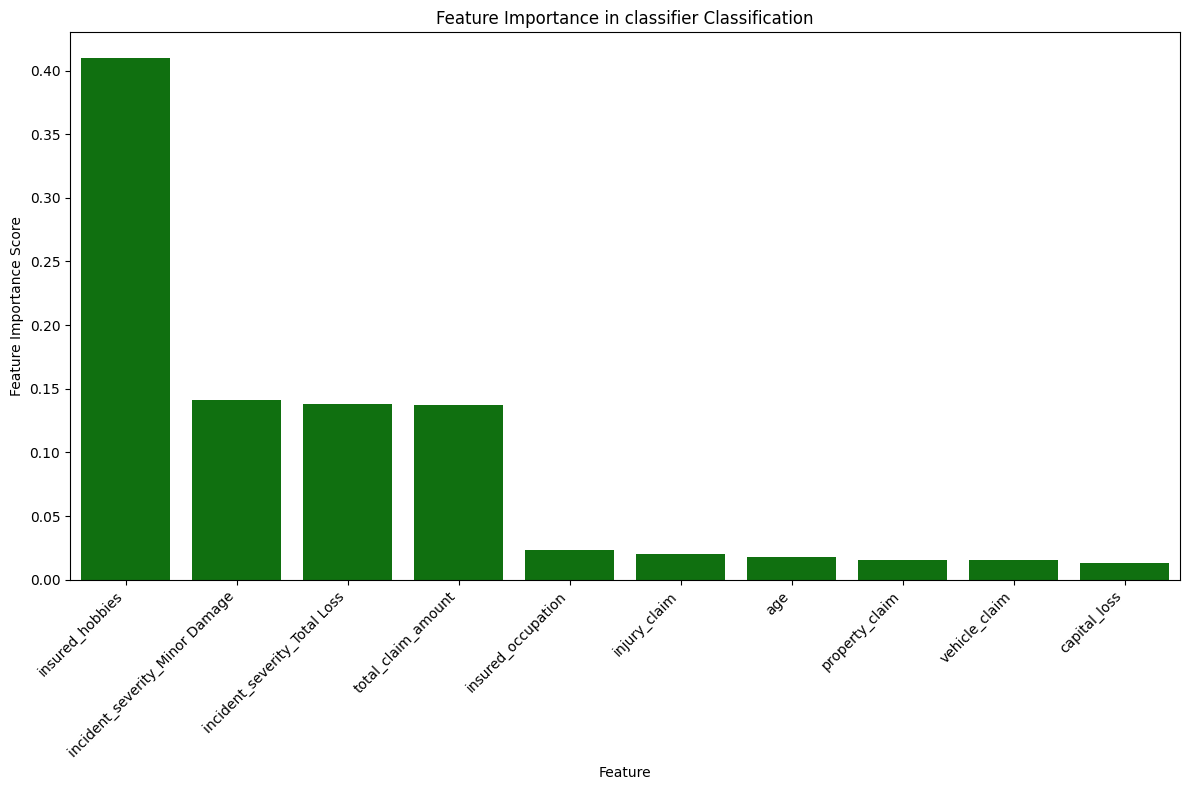

In [36]:
# Call the display feature importance function after model evaluation
display_feature_importance(fitted_model, X_train, y_train, feature_names, n_top=10)  # Specify how many top features to display

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_feature_importance(model, feature_names=None, top_n=20):
    """
    Plot the feature importance of a fitted tree-based model.

    Parameters:
    -----------
    model : estimator
        A fitted tree-based model with `feature_importances_` attribute (e.g., RandomForest, GradientBoosting).
    
    feature_names : list or None
        List of feature names. If None, numerical indices are used as feature names.
    
    top_n : int, default=20
        The number of top features to plot. If `None`, all features will be plotted.
    """
    # Check if the model has feature_importances_ attribute
    try:
        if not hasattr(model, 'feature_importances_'):
            importance_values = model.coef_[0]
        else:
            # Get feature importance values and sort them in descending order
            importance_values = model.feature_importances_
    except:
        raise ValueError("The model does not have `feature_importances_` attribute.")

    
    
    # Create a DataFrame for better manipulation and sorting
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(importance_values))]
    
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_values})
    
    # Sort features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # If top_n is specified, select the top_n features
    if top_n is not None and top_n < len(importance_df):
        importance_df = importance_df.head(top_n)
    
    # Plot the feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', palette='viridis', dodge=False, legend=False)
    plt.title('Top Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


In [38]:
fitted_model = pipeline.named_steps['model']
fitted_model

DecisionTreeClassifier(max_depth=22, min_samples_leaf=16, min_samples_split=14,
                       random_state=42)

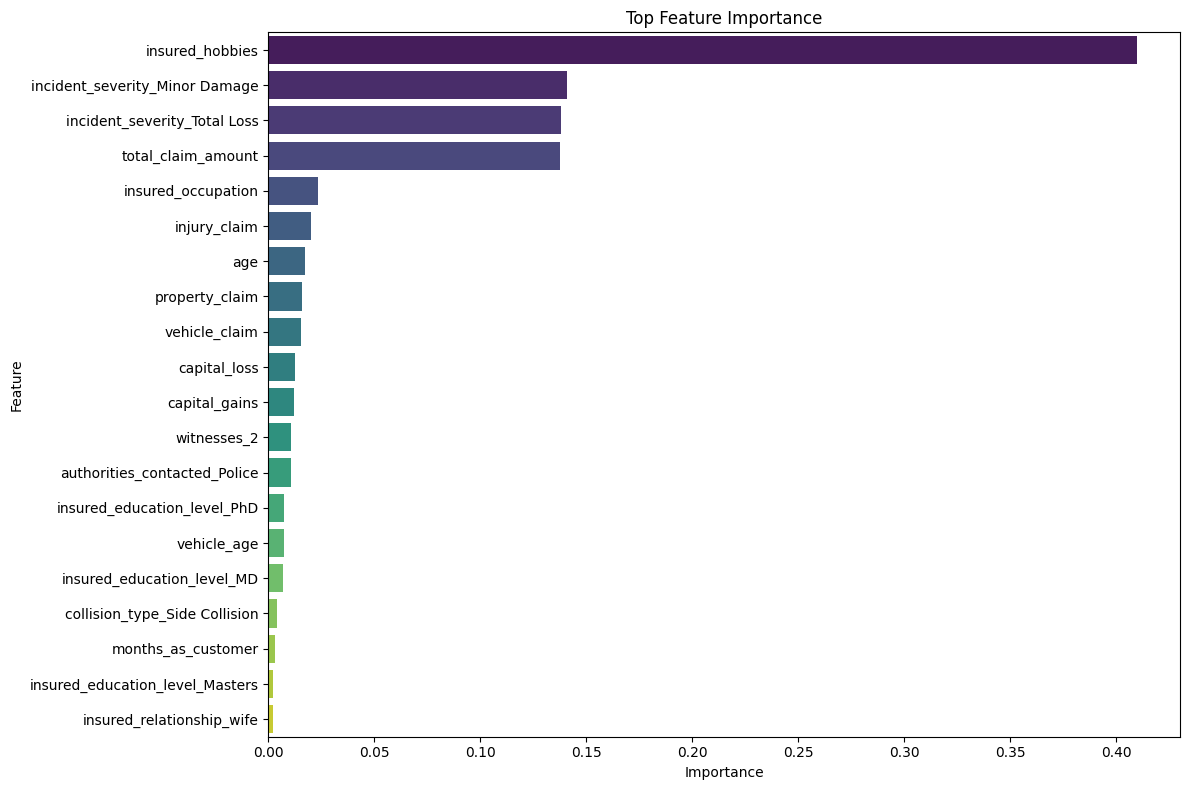

In [39]:
# Use the function to plot the feature importance
plot_feature_importance(fitted_model, feature_names=feature_names, top_n=20)